# Pair Potentials

In [1]:
%pip install -q matplotlib numpy pairinteraction

import matplotlib.pyplot as plt
import numpy as np
import pairinteraction.real as pi
from pairinteraction.visualization.colormaps import alphamagma

In [2]:
if pi.Database.get_global_database() is None:
    pi.Database.initialize_global_database(download_missing=True)

In [3]:
ket = pi.KetAtom("Rb", n=60, l=0, m=0.5)
basis = pi.BasisAtom("Rb", n=(56, 64), l=(0, 3))
print(f"Number of single-atom basis states: {basis.number_of_states}")
system = pi.SystemAtom(basis)

pair_energy = 2 * ket.get_energy(unit="GHz")
min_energy, max_energy = pair_energy - 10, pair_energy + 10

pair_basis = pi.BasisPair(
    [system, system], energy=(min_energy, max_energy), energy_unit="GHz", m=(1, 1)
)
print(f"Number of two-atom basis states: {pair_basis.number_of_states}")

distances = np.linspace(1, 4, 100)
pair_systems = [
    pi.SystemPair(pair_basis).set_distance(d, unit="micrometer") for d in distances
]

# Diagonalize the systems in parallel
pi.diagonalize(pair_systems, diagonalizer="eigen", sort_by_energy=True)

eigenenergies = [system.get_eigenenergies(unit="GHz") - pair_energy for system in pair_systems]
overlaps = [system.get_eigenbasis().get_overlaps([ket, ket]) for system in pair_systems]

Number of single-atom basis states: 288
Number of two-atom basis states: 547


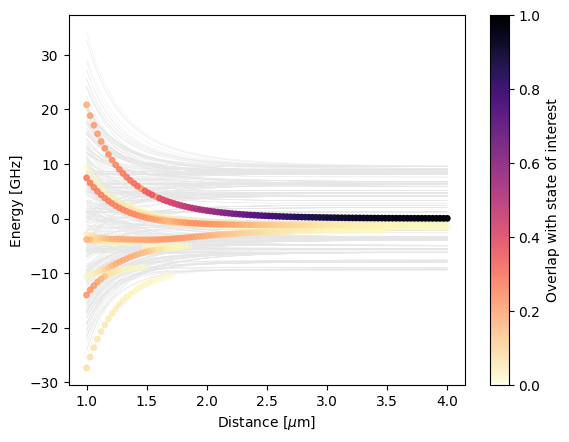

In [4]:
fig, ax = plt.subplots()

ax.set_xlabel(r"Distance [$\mu$m]")
ax.set_ylabel("Energy [GHz]")

try:
    ax.plot(distances, np.array(eigenenergies), c="0.9", lw=0.25, zorder=-10)
except ValueError:  # inhomogeneous shape -> no simple line plot possible
    for x, es in zip(distances, eigenenergies):
        ax.plot([x] * len(es), es, c="0.9", ls="None", marker=".", zorder=-10)

x_repeated = np.hstack([val * np.ones_like(es) for val, es in zip(distances, eigenenergies)])
energies_flattend = np.hstack(eigenenergies)
overlaps_flattend = np.hstack(overlaps)
sorter = np.argsort(overlaps_flattend)

scat = ax.scatter(
    x_repeated[sorter],
    energies_flattend[sorter],
    c=overlaps_flattend[sorter],
    s=15,
    vmin=0,
    vmax=1,
    cmap=alphamagma,
)

fig.colorbar(scat, ax=ax, label="Overlap with state of interest")

plt.show()